In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import yt

from galaxy_analysis.gizmo import yield_model
from galaxy_analysis.utilities import cy_convert_abundances as ca
from galaxy_analysis.plot.plot_styles import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm

import gizmo_analysis as gizmo
import utilities as gizmo_ut


#from galaxy_analysis.y

import os,sys

from scipy.stats import ks_2samp

input_type = 'mass'

In [59]:
class GizmoData:
    """
    General class to be able to easily load any Gizmo output file 
    and generate yield table model to post-process age-tracer derived
    abundances. Uses yt
    """

    def __init__(self, snapshot_path, yield_table = None,
                       yield_model_Z = 0.002, yield_model_FIRE_Z_scaling = True
                       ):
        
 
        
        self.work_dir = snapshot_path.split("output/snapshot_")[0]
        self.snapshot_name = snapshot_path.split("output/")[-1]

        index = int(self.snapshot_name.strip('.hdf5').split('_')[-1])
        self.part = gizmo.io.Read.read_snapshots(['star','dark'], 'index', index,
                                                 assign_host_principal_axes=True, 
                                                 simulation_directory = self.work_dir)
               
        
        
        if not (os.path.isfile(self.work_dir + 'output/snapshot_000.hdf5')):
            print("Cannot find initial snapshot file at " + self.work_dir + 'output/snapshot_000.hdf5')
            raise RuntimeError

        self.age_bins = yield_model.get_bins(config_file = self.work_dir + "/gizmo.out",
                                             binfile     = self.work_dir + "/age_bins.txt")

        self.yield_model_Z = None
        self.yield_model_FIRE_Z_scaling = None
        self.yield_model_age_fraction = None
        if yield_table is None:
            self.generate_yield_table(yield_model_Z, yield_model_FIRE_Z_scaling)
        else:
            self.yield_table = yield_table

        # load datasets and define fields
        self.ds0      = yt.load(self.work_dir + 'output/snapshot_000.hdf5')
        self.data0    = self.ds0.all_data()

        yield_model.generate_metal_fields(self.ds0, _agebins=self.age_bins,
                                                    _yields=self.yield_table,
                                                    age_is_fraction=True)

        self.metals   = np.unique([x[1] for x in self.ds0.field_list if ((x[0]=='PartType0')and('Metal' in x[1]))])

        self.initial_abundance = np.zeros(15)
        for i in np.arange(np.size(self.initial_abundance)):
            z = self.data0[('PartType0','Metallicity_%02i'%(i))]
            self.initial_abundance[i] = np.average(z).value # should all be identical
        self._logH = np.log10(self.ds0.hubble_constant)
        self._littleh = 1.0

        # load actual dataset
        self.ds       = yt.load(snapshot_path)
        self.data     = self.ds.all_data()

        yield_model.generate_metal_fields(self.ds,_agebins=self.age_bins,
                                         _yields=self.yield_table,age_is_fraction=True)
        yield_model._generate_star_metal_fields(self.ds, _agebins = self.age_bins,
                                         _yields = self.yield_table,age_is_fraction=True)


        self.loaded_fields = {}
        
        
        #
        #
        #

        
        return

    def generate_yield_table(self, yield_model_Z = 1.0E-3, yield_model_FIRE_Z_scaling = True):
        self.yield_model_Z              = yield_model_Z
        self.yield_model_FIRE_Z_scaling = yield_model_FIRE_Z_scaling
        self.yield_table = yield_model.construct_yields(self.age_bins/1000.0, # pass bins as Gyr, Z = Z,
                                    Z = self.yield_model_Z, yieldtype = 'total',
                                    FIRE_Z_scaling= self.yield_model_FIRE_Z_scaling)
        return

    def get_abund(self,e,ptype='star'):
        """
        Return abundance of given element for given particle type 
        from the simulation
        """
        if ptype == 'star':
            ptype = "PartType4"
        elif ptype == 'gas':
            ptype = "PartType0"
                        
        if e == "H":
            return 1.0 - self.data[(ptype,"Metallicity_00")] - self.data[(ptype,"Metallicity_01")]
        else:
            ei = yield_model.elements.index(e)

        return self.data[(ptype,"Metallicity_%02i"%(ei))]

    def get_age_abund(self,e,ptype='star'):
        """
        Return abundance of given element for given particle type as derived
        using age abundances.
        """
        
        if ptype == 'star':
            ptype = "PartType4"
        elif ptype == 'gas':
            ptype = "PartType0"
        if e == "H":
            # H_frac = 1.0 - self.data[(ptype,"Metallicity_00")] - self.data[(ptype,"Metallicity_01")]
            M = self.data[(ptype,'particle_mass')].to('Msun')
            H_frac = M*(1.0-self.initial_abundance[0]-self.initial_abundance[1])-\
                       self.data[('all',ptype+'_Total_mass')] / self._littleh - self.data[('all',ptype+'_He_mass')] / self._littleh
            H_frac = H_frac / self.data[(ptype,'particle_mass')].to('Msun')

            return H_frac
        else:
            ei = yield_model.elements.index(e)
            # very bad!!!
            mass = self.data[('all', ptype + '_' + e + '_mass')].to('Msun') / self._littleh
            norm = self.data[(ptype,'particle_mass')].to('Msun')
           # M_norm # (16752.063237698454*yt.units.Msun)
            Z = mass / norm
            Z = Z + self.initial_abundance[yield_model.elements.index(e)]
            return Z # mass/norm #+ self.initial_abundance[yield_model.elements.index(e)]
        
    def get_ratio(self,e1,e2,ptype="star",age=True, reload = False):
        """
        Return abundance ratio for a given particle type. If age is True,
        returns abundance ratio using age-tracer derived abundances. If false
        uses simulation abundances.
        """
        keystr = ''
        if age:
            keystr = '_age'
            
        field_key = ptype + '_' + e1 + '_over_' + e2 + keystr
                
        if not reload:
            # check if field is loadedptype + '_' + e1 + '_over_' + e2 + keystr
            if field_key in self.loaded_fields.keys():
                return self.loaded_fields[field_key]
        
        if age:
            vals1 = self.get_age_abund(e1)
            vals2 = self.get_age_abund(e2)
        else:
            vals1 = self.get_abund(e1)
            vals2 = self.get_abund(e2)
        self.loaded_fields[field_key] = ca.abundance_ratio_array(e1,vals1,e2,vals2,
                                        input_type="mass")
        
        return self.loaded_fields[field_key]

    def get_difference(self,e1,e2, absval=True, ptype = 'star', reload = False):
        """
        For a given particle type, computes the difference/offset (in dex)
        between a given abundance ratio for each particle between 
        the "true" simulated abundances and the age-tracer
        derived abundances.
        """
            
        field_key = ptype + '_' + e1 + '_over_' + e2 + '_difference'
        
        if not reload:
            if field_key in self.loaded_fields.keys():
                return self.loaded_fields[field_key]
        
        x1_vals_age = self.get_age_abund(e1,ptype=ptype)
        x2_vals_age = self.get_age_abund(e2,ptype=ptype)

        x1_vals = self.get_abund(e1,ptype=ptype)
        x2_vals = self.get_abund(e2,ptype=ptype)

        abund_age  = ca.abundance_ratio_array(e1, x1_vals_age, e2, x2_vals_age,
                                      input_type="mass")
        abund  = ca.abundance_ratio_array(e1, x1_vals, e2, x2_vals,
                                      input_type="mass")
        cutvals1 = self.get_abund('O',ptype=ptype)
        cutvals2 = self.get_abund('H',ptype=ptype)
        H_cut = ca.abundance_ratio_array('O',cutvals1,'H',cutvals2,input_type="mass")
        #abund     = abund[ (H_cut > -2.6)]
        #abund_age = abund_age[ (H_cut > -2.6)]

        if absval:
            abund = np.abs(abund - abund_age) # diff
        else:
            abund = abund-abund_age

            
        self.loaded_fields[field_key] = abund
        
        return self.loaded_fields[field_key]

    def MDF(self, x1e,x2e,rmin=None,rmax=None,
            dbin=0.25, age=True, ptype='star', diff = False, absval=False):
        """
        Given two elements, returns the 1D MDF for that element.
        
        Parameters
        ----------
        x1e   :   str
            Numerator for abundance ratio. The 'A' of [A/B].
        x2e   :   str 
            Denominator for abundance ratio. The 'B' of [A/B].
        rmin  :   float, optional
            Minimum value for histogram (in dex). Default None, taken to be min of data
        rmax  :   float, optional
            Maximum value for histogram. Default: None, taken to be max of data
        dbin  :   float, optional
            MDF histogram bin spacing (in dex). Default: 0.25
        age   :   bool, optional
            If True, use age-tracer derived abundances. If False, use "true" simulation
            abundances. Default: True
        ptype :   str, optional
            Particle type to compute. Can be either 'star', 'gas', or any of the available
            "PartTypeN", where N is a number. Default: 'star'
        diff  :   bool, optional
            If True, 'age' paramter is ignored and computed the difference histogram
            of the abundance ratios for the simulated abundances - the age tracer derived
            abundances. Recommened to manually enter values for dbin, rmin, and rmax in this
            case. Default: False
        absval :  bool, optional
            Only used if diff is True. Compute the absolute value of the difference.
            Default: False
            
        Returns:
        --------
        bins   :  np.ndarray, float
            MDF bins
        hist   : np.ndarray, float
            MDF histogram values
        stats  : dict
            Optional. Only returned if diff is True. Dictionary containing
            various statistics for the dataset, including mean, median,
            std, 1st and 3rd quartiles, 1st and 9th decile, IQR, IDR,
            and fraction of points with differences (in dex) less than or equal to
            certain values (0.2, 0.1, 0.05, 0.02, 0.01, 0.005).
        """

        if (absval) and (not diff):
            print("Are you sure you want to take the absolute value of hte abundance if it is not a diff?")
            raise ValueError

        if diff:
            x1_vals_age = self.get_age_abund(x1e,ptype=ptype)
            x2_vals_age = self.get_age_abund(x2e,ptype=ptype)        

            x1_vals = self.get_abund(x1e,ptype=ptype)
            x2_vals = self.get_abund(x2e,ptype=ptype)

            abund_age  = ca.abundance_ratio_array(x1e, x1_vals_age, x2e, x2_vals_age,
                                          input_type="mass")
            abund  = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                          input_type="mass")
            cutvals1 = self.get_abund('O',ptype=ptype)
            cutvals2 = self.get_abund('H',ptype=ptype)       
            H_cut = ca.abundance_ratio_array('O',cutvals1,'H',cutvals2,input_type="mass")
            #abund     = abund[ (H_cut > -2.6)]        
            #abund_age = abund_age[ (H_cut > -2.6)]

            if absval:
                abund = np.abs(abund - abund_age) # diff
            else:
                abund = abund-abund_age

        else:
            if age:
                x1_vals = self.get_age_abund(x1e,ptype=ptype)
                x2_vals = self.get_age_abund(x2e,ptype=ptype)
            else:
                x1_vals = self.get_abund(x1e,ptype=ptype)
                x2_vals = self.get_abund(x2e,ptype=ptype)

            abund  = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                      input_type="mass")        
            if ptype == 'gas':
                cutvals1 = self.get_abund('O',ptype=ptype)
                cutvals2 = self.get_abund('H',ptype=ptype)       

                H_cut = ca.abundance_ratio_array('O',cutvals1,'H',cutvals2,input_type="mass")

                abund     = abund[ (H_cut > -2.6)]        

        if rmin is None:
            rmin = np.min(abund)
        if rmax is None:
            rmax = np.max(abund)

        nbins = int((rmax - rmin)/dbin)
        hist, bins = np.histogram(abund, bins = nbins, range = (rmin,rmax))
        hist2 = np.ones(np.size(hist)+1)
        hist2[:-1] = hist
        hist2[-1] = hist2[-2]

        stats = {'median' : np.median(abund), 'mean' : np.average(abund),
                 'Q1'     : np.quantile(abund,0.25), 'Q3' : np.quantile(abund,0.75),
                 'IQR'    : np.quantile(abund,0.75) - np.quantile(abund,0.25),
                 'std'    : np.std(abund), 'D9' : np.quantile(abund,0.9), 'D1' : np.quantile(abund,0.1) }

        # compute fraction < a given offset
        if diff:
            stats['0.2dex']   = np.size( abund[ np.abs(abund) < 0.2  ]) / (1.0*np.size(abund))
            stats['0.1dex']   = np.size( abund[ np.abs(abund) < 0.1  ]) / (1.0*np.size(abund))
            stats['0.05dex']  = np.size( abund[ np.abs(abund) < 0.05 ]) / (1.0*np.size(abund))
            stats['0.02dex']  = np.size( abund[ np.abs(abund) < 0.02 ]) / (1.0*np.size(abund))
            stats['0.01dex']  = np.size( abund[ np.abs(abund) < 0.01 ]) / (1.0*np.size(abund))
            stats['0.005dex'] = np.size( abund[ np.abs(abund) < 0.005]) / (1.0*np.size(abund))
        if diff:
            return bins,hist2,stats
        else:
            return bins, hist2


In [113]:
#
# How to generate yields:
#
simulation = 'm12q'
wdir = "/home/aemerick/work/gizmo_runs/m12q_res5700_test/"

# load the data set
gizmo_data = GizmoData(wdir + '/output/' + 'snapshot_342.hdf5',
                       # yield_table = None, # set to supply self-generated yield table
                       # to have the obj generate the FIRE yield table:
                       yield_model_Z = 1.0E-3,                  # Z of yield model
                       yield_model_FIRE_Z_scaling = True        # default True. use Z scaling in Fire model
                      )
gizmo_data_solar = GizmoData(wdir + '/output/' + 'snapshot_342.hdf5',
                       # yield_table = None, # set to supply self-generated yield table
                       # to have the obj generate the FIRE yield table:
                       yield_model_Z = 1.0E-2,                  # Z of yield model
                       yield_model_FIRE_Z_scaling = True        # default True. use Z scaling in Fire model
                      )
gizmo_data_lowz = GizmoData(wdir + '/output/' + 'snapshot_342.hdf5',
                       # yield_table = None, # set to supply self-generated yield table
                       # to have the obj generate the FIRE yield table:
                       yield_model_Z = 1.0E-4,                  # Z of yield model
                       yield_model_FIRE_Z_scaling = True        # default True. use Z scaling in Fire model
                      )


# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/m12q_res5700_test//snapshot_times.txt

  using snapshot index = 342, redshift = 0.657


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/m12q_res5700_test//output/snapshot_342.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 16220880 particles
    dark2     (id = 2): 4132251 particles
    gas       (id = 0): 13934177 particles
    star      (id = 4): 2289317 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'dark']
* reading particles from:
    home/aemerick/work/gizmo_runs/m12q_res5700_test//output/snapshot_342.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/m12q_res5700_test//*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties


In [15]:
gizmo_data.get_ratio('Fe','H',age=True)

array([-1.67067446, -1.61346532, -2.46036898, ..., -1.19307869,
       -3.88055278, -1.30866375])

In [6]:
#
#
# 
#
#
gizmo_data.ds.derived_field_list

[('PartType0', 'Acceleration'),
 ('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'H_nuclei_density'),
 ('PartType0', 'He_nuclei_density'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity_00'),
 ('PartType0', 'Metallicity_01'),
 ('PartType0', 'Metallicity_02'),
 ('PartType0', 'Metallicity_03'),
 ('PartType0', 'Metallicity_04'),
 ('PartType0', 'Metallicity_05'),
 ('PartType0', 'Metallicity_06'),
 ('PartType0', 'Metallicity_07'),
 ('PartType0', 'Metallicity_08'),
 ('PartType0', 'Metallicity_09'),
 ('PartType0', 'Metallicity_10'),
 ('PartType0', 'Metallicity_11'),
 ('PartType0', 'Metallicity_12'),
 ('PartType0', 'Metallicity_13'),
 ('PartType0', 'Metallicity_14'),
 ('PartType0', 'Metallicity_15'),
 ('PartType0', 'Metallicity_16'),
 ('PartType0', 'Metallicity_17'),
 ('PartType0', 'Metallicity_18'),
 ('PartType0', 'Metallicity_19'),
 ('PartType0', 'Metallicity_20'),
 ('PartType0', 'Metallicit

Correlation Values for field           StellarFormationTime :    0.129
Correlation Values for field                    metallicity :    0.065
Correlation Values for field    particle_velocity_magnitude :    0.029
Correlation Values for field                         radius :    -0.125
----------------------------------------------------------------------
Correlation Values for field           StellarFormationTime :    0.192
Correlation Values for field                    metallicity :    0.585
Correlation Values for field    particle_velocity_magnitude :    0.102
Correlation Values for field                         radius :    -0.452


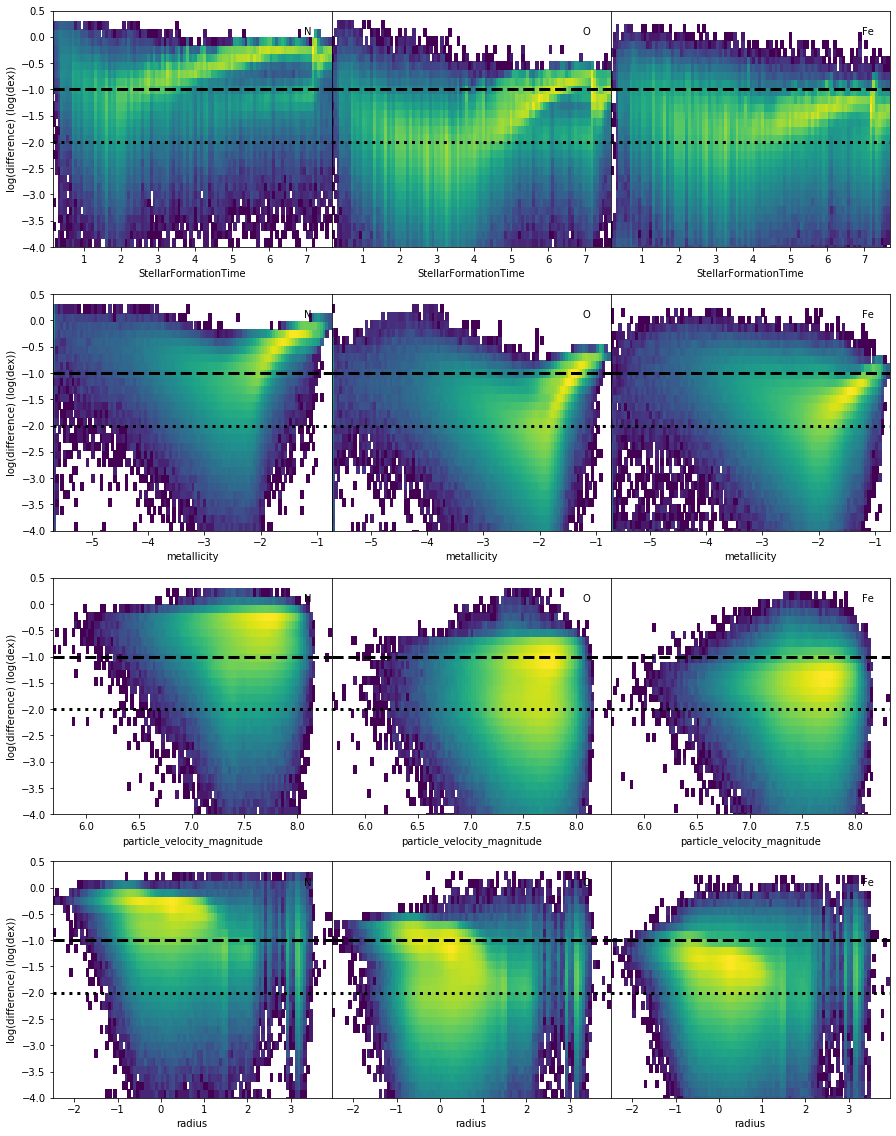

In [112]:
#
#
# Identify what (if any) correlations with error and particle types
#
#
ptype  = 'PartType4'
fields = ['StellarFormationTime', 
          'metallicity', 
          'particle_velocity_magnitude', 'radius']

field_lim = {'StellarFormationTime' : (0.0 , 10.0),
             'metallicity'          : (1.0E-5, 1.0),
             'particle_velocity_magnitude': (0.0, 1000.0),
             'radius' : (-3,3)}

field_units = {'StellarFormationTime' : 'Gyr',
               #'metallicity' : ''
               'particle_velocity_magnitude' : 'km/s'}

field_log  = {'StellarFormationTime' : False, 'metallicity' : True,
              'particle_velocity_magnitude' : True, 'radius' : True}


field_labels={}
for k in fields:
    field_labels[k] = k

elements = ['N','O','Fe']

# compute differences
diff = {}
for e in elements:
    diff[e] = gizmo_data.get_difference(e, 'H', absval=True)
    
# compute statistics

nrow = len(fields)
ncol = len(elements)

fig, ax = plt.subplots(len(fields), len(elements))
fig.set_size_inches(5*len(elements), 5*len(fields))

fig.subplots_adjust(wspace=0)

corr = {}

corr['5gyr'] = {}

for axi in np.arange(nrow):
    
    field = fields[axi]
    
    if field == 'StellarFormationTime':
        field_data = gizmo_data.part['star'].prop('form.time')
    elif field == 'radius':
        pos = gizmo_data.part['star'].prop('host.distance.pos')
        
        field_data = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    else:
        field_name = (ptype, field)
        field_data = gizmo_data.data[field_name]
    
    #if field in field_units:
    #    field_data = field_data.to(field_units[field])
        
    if field in field_log:
        if field_log[field]:
            field_data = np.log10(field_data)
    
    for axj in np.arange(ncol):
        e = elements[axj]

        axindex = (axi,axj)
        
        xplot = field_data[ diff[e] > 0 ]
        yplot = np.log10(diff[e][ diff[e] > 0 ])
        
        #print(diff[e][ diff[e] < 0])

        ax[axindex].hist2d(xplot, yplot, bins = 100, norm = LogNorm())
        
        
        ax[axindex].set_xlabel(field_labels[field])
        
        if axj > 0:
            ax[axindex].set_yticks([])
        else:
            ax[axindex].set_ylabel('log(difference) (log(dex))')
            
        ax[axindex].set_ylim(-4, 0.5)
        
        ax[axindex].set_xlim( ax[axindex].get_xlim())
        ax[axindex].plot(ax[axindex].get_xlim(), [-1,-1], lw = 3, color = 'black', ls = '--')
        ax[axindex].plot(ax[axindex].get_xlim(), [-2,-2], lw = 3, color = 'black', ls = ':')
        
        xy = (0.9,0.9)
        ax[axindex].annotate(e, xy=xy,xytext=xy, xycoords='axes fraction')
        
    
        corr[field] = np.corrcoef(diff[e], field_data)
        
        select = gizmo_data.part['star'].prop('form.time') > 5.0

        
        corr['5gyr'][field] = np.corrcoef(diff[e][select], field_data[select])
    
for k in fields:
    print("Correlation Values for field %30s :    %5.3f"%(k,corr[k][0,1]))
print("----------------------------------------------------------------------")
for k in fields:
    print("Correlation Values for field %30s :    %5.3f"%(k,corr['5gyr'][k][0,1]))
    

Correlation Values for field           StellarFormationTime :    0.208
Correlation Values for field                    metallicity :    0.153
Correlation Values for field    particle_velocity_magnitude :    0.041
Correlation Values for field                         radius :    -0.162
----------------------------------------------------------------------
Correlation Values for field           StellarFormationTime :    0.184
Correlation Values for field                    metallicity :    0.643
Correlation Values for field    particle_velocity_magnitude :    0.114
Correlation Values for field                         radius :    -0.491


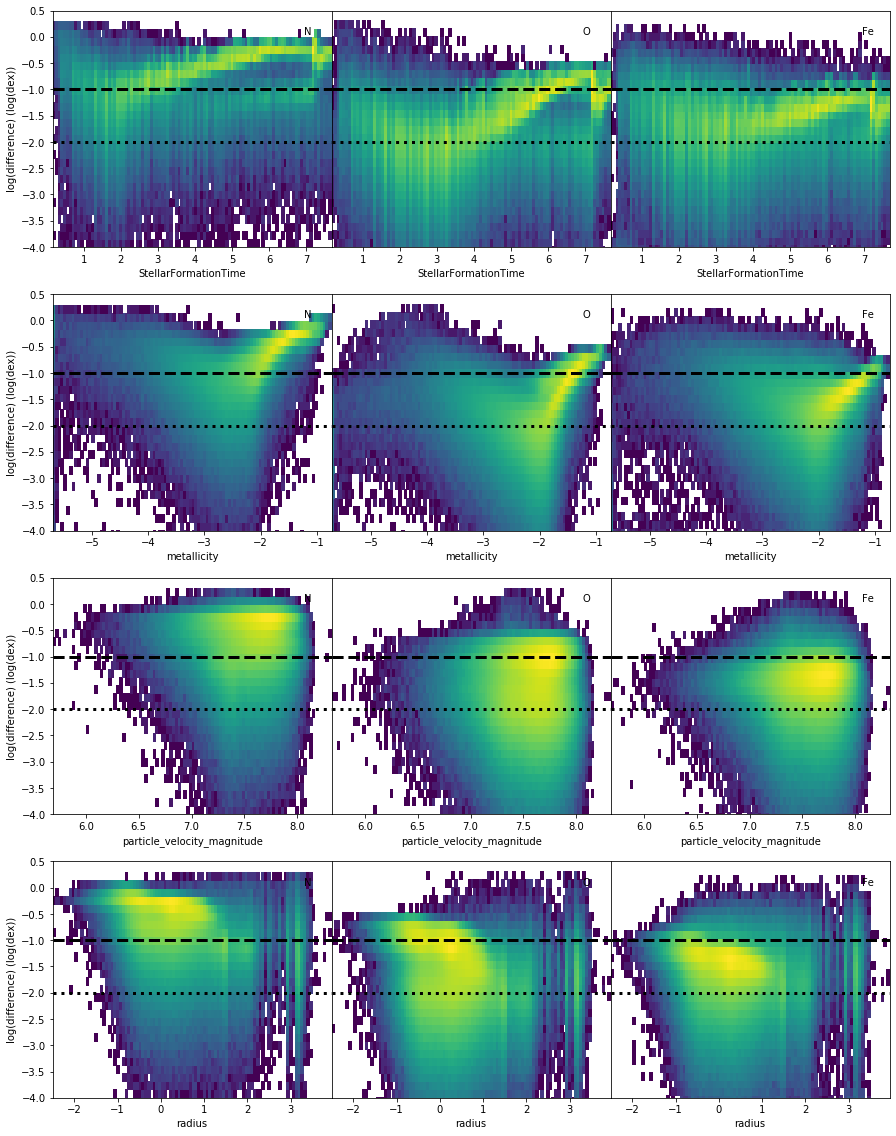

In [117]:
#
#
# Identify what (if any) correlations with error and particle types
#
#
ptype  = 'PartType4'
fields = ['StellarFormationTime', 
          'metallicity', 
          'particle_velocity_magnitude', 'radius']

field_lim = {'StellarFormationTime' : (0.0 , 10.0),
             'metallicity'          : (1.0E-5, 1.0),
             'particle_velocity_magnitude': (0.0, 1000.0),
             'radius' : (-3,3)}

field_units = {'StellarFormationTime' : 'Gyr',
               #'metallicity' : ''
               'particle_velocity_magnitude' : 'km/s'}

field_log  = {'StellarFormationTime' : False, 'metallicity' : True,
              'particle_velocity_magnitude' : True, 'radius' : True}


field_labels={}
for k in fields:
    field_labels[k] = k

elements = ['N','O','Fe']

# compute differences
diff = {}
for e in elements:
    diff[e] = gizmo_data_lowz.get_difference(e, 'H', absval=True)
    
# compute statistics

nrow = len(fields)
ncol = len(elements)

fig, ax = plt.subplots(len(fields), len(elements))
fig.set_size_inches(5*len(elements), 5*len(fields))

fig.subplots_adjust(wspace=0)

corr = {}

corr['5gyr'] = {}

for axi in np.arange(nrow):
    
    field = fields[axi]
    
    if field == 'StellarFormationTime':
        field_data = gizmo_data_lowz.part['star'].prop('form.time')
    elif field == 'radius':
        pos = gizmo_data_lowz.part['star'].prop('host.distance.pos')
        
        field_data = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    else:
        field_name = (ptype, field)
        field_data = gizmo_data_lowz.data[field_name]
    
    #if field in field_units:
    #    field_data = field_data.to(field_units[field])
        
    if field in field_log:
        if field_log[field]:
            field_data = np.log10(field_data)
    
    for axj in np.arange(ncol):
        e = elements[axj]

        axindex = (axi,axj)
        
        xplot = field_data[ diff[e] > 0 ]
        yplot = np.log10(diff[e][ diff[e] > 0 ])
        
        #print(diff[e][ diff[e] < 0])

        ax[axindex].hist2d(xplot, yplot, bins = 100, norm = LogNorm())
        
        
        ax[axindex].set_xlabel(field_labels[field])
        
        if axj > 0:
            ax[axindex].set_yticks([])
        else:
            ax[axindex].set_ylabel('log(difference) (log(dex))')
            
        ax[axindex].set_ylim(-4, 0.5)
        
        ax[axindex].set_xlim( ax[axindex].get_xlim())
        ax[axindex].plot(ax[axindex].get_xlim(), [-1,-1], lw = 3, color = 'black', ls = '--')
        ax[axindex].plot(ax[axindex].get_xlim(), [-2,-2], lw = 3, color = 'black', ls = ':')
        
        xy = (0.9,0.9)
        ax[axindex].annotate(e, xy=xy,xytext=xy, xycoords='axes fraction')
        
    
        corr[field] = np.corrcoef(diff[e], field_data)
        
        select = gizmo_data_lowz.part['star'].prop('form.time') > 5.0

        
        corr['5gyr'][field] = np.corrcoef(diff[e][select], field_data[select])
    
for k in fields:
    print("Correlation Values for field %30s :    %5.3f"%(k,corr[k][0,1]))
print("----------------------------------------------------------------------")
for k in fields:
    print("Correlation Values for field %30s :    %5.3f"%(k,corr['5gyr'][k][0,1]))
    

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: RuntimeWarning: invalid value encountered in log10
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


Correlation Values for field           StellarFormationTime :      nan
Correlation Values for field                    metallicity :      nan
Correlation Values for field    particle_velocity_magnitude :      nan
Correlation Values for field                         radius :      nan
----------------------------------------------------------------------
Correlation Values for field           StellarFormationTime :    -0.001
Correlation Values for field                    metallicity :    0.272
Correlation Values for field    particle_velocity_magnitude :    0.007
Correlation Values for field                         radius :    -0.097


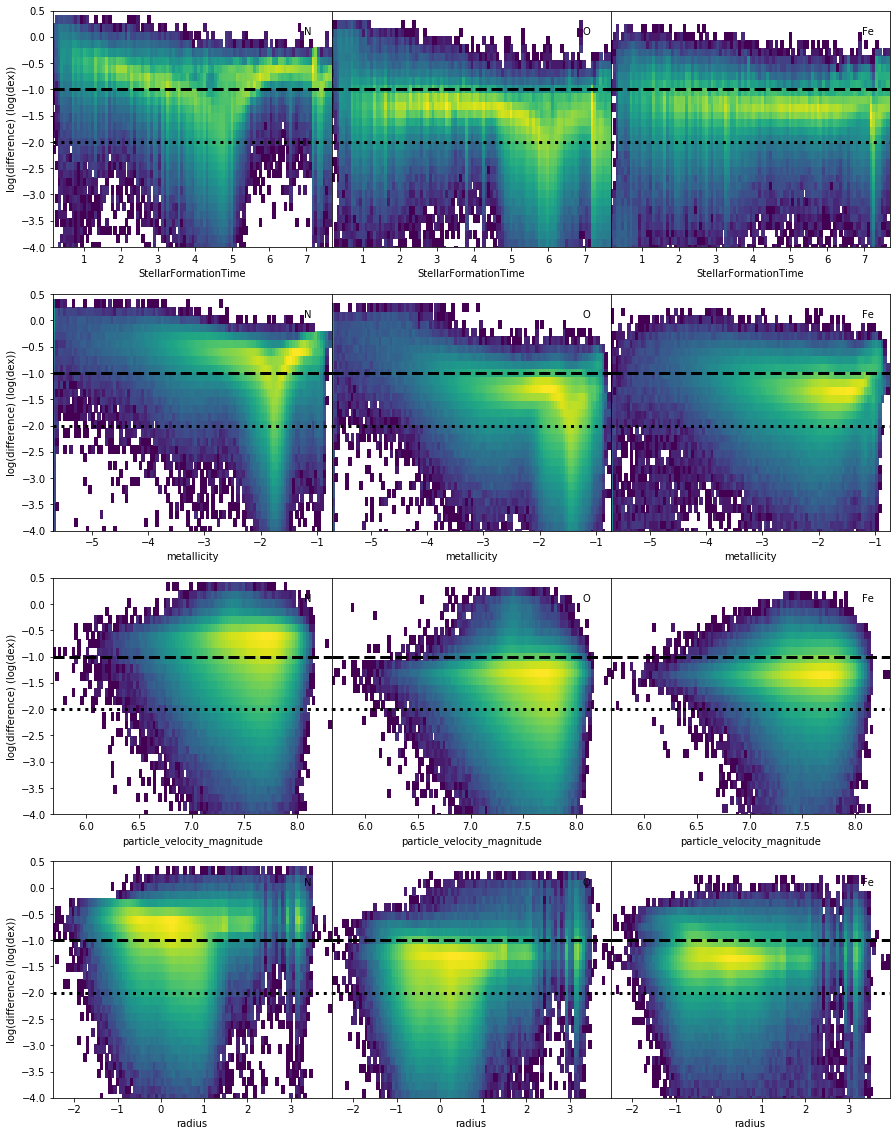

In [116]:
#
#
# Identify what (if any) correlations with error and particle types
#
#
ptype  = 'PartType4'
fields = ['StellarFormationTime', 
          'metallicity', 
          'particle_velocity_magnitude', 'radius']

field_lim = {'StellarFormationTime' : (0.0 , 10.0),
             'metallicity'          : (1.0E-5, 1.0),
             'particle_velocity_magnitude': (0.0, 1000.0),
             'radius' : (-3,3)}

field_units = {'StellarFormationTime' : 'Gyr',
               #'metallicity' : ''
               'particle_velocity_magnitude' : 'km/s'}

field_log  = {'StellarFormationTime' : False, 'metallicity' : True,
              'particle_velocity_magnitude' : True, 'radius' : True}


field_labels={}
for k in fields:
    field_labels[k] = k

elements = ['N','O','Fe']

# compute differences
diff = {}
for e in elements:
    diff[e] = gizmo_data_solar.get_difference(e, 'H', absval=True)
    
# compute statistics

nrow = len(fields)
ncol = len(elements)

fig, ax = plt.subplots(len(fields), len(elements))
fig.set_size_inches(5*len(elements), 5*len(fields))

fig.subplots_adjust(wspace=0)

corr = {}

corr['5gyr'] = {}

for axi in np.arange(nrow):
    
    field = fields[axi]
    
    if field == 'StellarFormationTime':
        field_data = gizmo_data_solar.part['star'].prop('form.time')
    elif field == 'radius':
        pos = gizmo_data_solar.part['star'].prop('host.distance.pos')
        
        field_data = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    else:
        field_name = (ptype, field)
        field_data = gizmo_data_solar.data[field_name]
    
    #if field in field_units:
    #    field_data = field_data.to(field_units[field])
        
    if field in field_log:
        if field_log[field]:
            field_data = np.log10(field_data)
    
    for axj in np.arange(ncol):
        e = elements[axj]

        axindex = (axi,axj)
        
        xplot = field_data[ diff[e] > 0 ]
        yplot = np.log10(diff[e][ diff[e] > 0 ])
        
        #print(diff[e][ diff[e] < 0])

        ax[axindex].hist2d(xplot, yplot, bins = 100, norm = LogNorm())
        
        
        ax[axindex].set_xlabel(field_labels[field])
        
        if axj > 0:
            ax[axindex].set_yticks([])
        else:
            ax[axindex].set_ylabel('log(difference) (log(dex))')
            
        ax[axindex].set_ylim(-4, 0.5)
        
        ax[axindex].set_xlim( ax[axindex].get_xlim())
        ax[axindex].plot(ax[axindex].get_xlim(), [-1,-1], lw = 3, color = 'black', ls = '--')
        ax[axindex].plot(ax[axindex].get_xlim(), [-2,-2], lw = 3, color = 'black', ls = ':')
        
        xy = (0.9,0.9)
        ax[axindex].annotate(e, xy=xy,xytext=xy, xycoords='axes fraction')
        
    
        corr[field] = np.corrcoef(diff[e], field_data)
        
        select = gizmo_data_solar.part['star'].prop('form.time') > 5.0

        
        corr['5gyr'][field] = np.corrcoef(diff[e][select], field_data[select])
    
for k in fields:
    print("Correlation Values for field %30s :    %5.3f"%(k,corr[k][0,1]))
print("----------------------------------------------------------------------")
for k in fields:
    print("Correlation Values for field %30s :    %5.3f"%(k,corr['5gyr'][k][0,1]))
    

In [98]:
pos = gizmo_data.part['star'].prop('host.near.distance')
r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)

In [105]:
np.corrcoef(diff['Fe'],field_data)[0,1]

-0.12514445644408081